# Model 1b - MLPRegressor with standardization

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import math
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import  mean_squared_error

from openpyxl import load_workbook

In [2]:
# get data
parentdir = os.path.dirname(os.getcwd())
data = pd.read_excel(parentdir+'\\Data\\SWedge Results.xlsx',sheet_name = "Probabilistic Values", engine='openpyxl')
data.head()

,Wedge ID,Safety Factor,Wedge Volume (m3),Wedge Weight (MN),Plunge Line of Intersection (°),Trend Line of Intersection (°),Length Line of Intersection (m),Plunge Line of Intersection Basal-Joint1 (°),Trend Line of Intersection Basal-Joint1 (°),Length Line of Intersection Basal-Joint1 (m),...,Water Pressure Joint 2 (MPa),Water Pressure Basal Joint (MPa),Water Pressure Tension Crack (MPa),Ponded Water Depth (m),Seismic Alpha,Seismic Plunge (°),Seismic Trend (°),Maximum Persistence Joint 1 (m),Maximum Persistence Joint 2 (m),Maximum Persistence Basal Joint (m)
0,BFA 60 [0],1.082239,6349.248707,171.429715,31.846178,161.418240,56.856884,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1,BFA 60 [1],1.203906,7701.148241,207.931003,31.905513,168.542870,56.762278,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
2,BFA 60 [2],0.896601,2341.641868,63.224330,36.973415,150.874977,49.879923,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
3,BFA 60 [3],0.680996,155.345062,4.194317,54.969435,195.219985,36.636928,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
4,BFA 60 [4],1.263948,7468.340623,201.645197,29.688564,178.765625,60.571151,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN


In [3]:
print(np.shape(data))

(5000, 87)


In [4]:
# get data specifically for the modelling (i.e., the inputs and output)
data_model = data[["Safety Factor","Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
print(np.shape(data_model))
data_model.head()

(5000, 9)


,Safety Factor,Dip of Joint 1 (°),Dip Direction of Joint 1 (°),Dip of Joint 2 (°),Dip Direction of Joint 2 (°),Dip of Slope (°),Dip Direction of Slope (°),Friction Angle of Joint 1 (°),Friction Angle of Joint 2 (°)
0,1.082239,39.265808,120.865923,51.646228,221.979277,58.840543,182.626968,29.567773,29.522638
1,1.203906,38.981309,128.836961,57.766382,235.428421,63.804918,181.820235,32.713619,29.079492
2,0.896601,42.032968,117.504566,62.427355,217.726775,58.134485,180.398207,29.660213,27.455866
3,0.680996,69.264568,137.906910,66.183726,246.195109,61.968796,182.439496,30.866657,34.401616
4,1.263948,46.728166,121.226945,50.803809,241.060589,60.832522,179.091174,28.789453,28.613525


In [5]:
# remove any realizations that are not kinematically possible and any duplicates
data_model =  data_model.dropna()
data_model = data_model.drop_duplicates()
print(np.shape(data_model))

(4992, 9)


## Learning curves for different train_test_split random_states

Variable random_state (=0, 1, 42, 123) for train_test_split.

In [6]:
num_samples = []

r2_train_subsample_list = []
rmse_train_subsample_list = []
r2_test_subsample_list = []
rmse_test_subsample_list = []

random_state_val = [0,1,42,123]

for x in range(0,4):

    # dataset up to 4950 data points
    for i in range(100, 5000, 50):

        num_samples.append(i)

        # get subsample of data
        data_subsample = data_model.sample(n = i,random_state = 1)

        # train/test split with different random_state values (0, 1, 42, and 123)
        train_subsample, test_subsample = train_test_split(data_subsample, test_size=0.2, random_state=random_state_val[x])

        x_train_subsample = train_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
        y_train_subsample = train_subsample[["Safety Factor"]]
        y_train_subsample = np.ravel(y_train_subsample)
        
        x_test_subsample = test_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
        y_test_subsample = test_subsample[["Safety Factor"]]
        y_test_subsample = np.ravel(y_test_subsample)

        # train basic mlp model with default hyperparameters
        # make pipeline for mlp with pre-processing (standardizing the data)
        pipe_mlp = make_pipeline(StandardScaler(), MLPRegressor(random_state = 123))
        pipe_mlp.fit(x_train_subsample, y_train_subsample)

        ypred_mlp = pipe_mlp.predict(x_train_subsample)
        ypred_mlp = np.reshape(ypred_mlp,(len(ypred_mlp),1))

        # training r2 and rmse
        r2_train_subsample = pipe_mlp.score(x_train_subsample,y_train_subsample)
        rmse_train_subsample = math.sqrt(mean_squared_error(y_train_subsample,ypred_mlp))

        # append training r2 and rmse to their respective lists
        r2_train_subsample_list.append(r2_train_subsample)
        rmse_train_subsample_list.append(rmse_train_subsample)
  
        # test the mlp model
        # predict y test
        ypred_test_mlp = pipe_mlp.predict(x_test_subsample)
        ypred_test_mlp = np.reshape(ypred_test_mlp,(len(ypred_test_mlp),1))

        # test r2 and rmse
        r2_test_subsample = pipe_mlp.score(x_test_subsample,y_test_subsample)
        rmse_test_subsample = math.sqrt(mean_squared_error(y_test_subsample,ypred_test_mlp))

        # append test r2 and rmse to their respective lists
        r2_test_subsample_list.append(r2_test_subsample)
        rmse_test_subsample_list.append(rmse_test_subsample)
    
    # entire dataset
    num_samples.append(len(data_model.index))

    # get subsample of data
    data_subsample = data_model.sample(n = len(data_model.index),random_state = 1)

    # train/test split with different random_state values (0, 1, 42, and 123)
    train_subsample, test_subsample = train_test_split(data_subsample, test_size=0.2, random_state=random_state_val[x])

    x_train_subsample = train_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
    y_train_subsample = train_subsample[["Safety Factor"]]
    y_train_subsample = np.ravel(y_train_subsample)

    x_test_subsample = test_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
    y_test_subsample = test_subsample[["Safety Factor"]]
    y_test_subsample = np.ravel(y_test_subsample)

    # train basic mlp model with default hyperparameters
    # make pipeline for mlp with pre-processing (standardizing the data)
    pipe_mlp = make_pipeline(StandardScaler(), MLPRegressor(random_state = 123))
    pipe_mlp.fit(x_train_subsample, y_train_subsample)

    ypred_mlp = pipe_mlp.predict(x_train_subsample)
    ypred_mlp = np.reshape(ypred_mlp,(len(ypred_mlp),1))

    # training r2 and rmse
    r2_train_subsample = pipe_mlp.score(x_train_subsample,y_train_subsample)
    rmse_train_subsample = math.sqrt(mean_squared_error(y_train_subsample,ypred_mlp))

    # append training r2, rmse, and mape to their respective lists
    r2_train_subsample_list.append(r2_train_subsample)
    rmse_train_subsample_list.append(rmse_train_subsample)

    # test the mlp model
    # predict y test
    ypred_test_mlp = pipe_mlp.predict(x_test_subsample)
    ypred_test_mlp = np.reshape(ypred_test_mlp,(len(ypred_test_mlp),1))

    # test r2 and rmse
    r2_test_subsample = pipe_mlp.score(x_test_subsample,y_test_subsample)
    rmse_test_subsample = math.sqrt(mean_squared_error(y_test_subsample,ypred_test_mlp))

    # append testing r2, rmse, and mape to their respective lists
    r2_test_subsample_list.append(r2_test_subsample)
    rmse_test_subsample_list.append(rmse_test_subsample)


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multi

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multi

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multi

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multi

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multi

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multi

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multi

In [7]:
# transform lists of results into dataframes
num_samples = pd.DataFrame(num_samples)

r2_train_subsample_list = pd.DataFrame(r2_train_subsample_list)
rmse_train_subsample_list = pd.DataFrame(rmse_train_subsample_list)
r2_test_subsample_list = pd.DataFrame(r2_test_subsample_list)
rmse_test_subsample_list = pd.DataFrame(rmse_test_subsample_list)

In [8]:
# concatenate dataframes into one result dataframe
rslts = pd.concat([num_samples,r2_train_subsample_list,rmse_train_subsample_list,r2_test_subsample_list,rmse_test_subsample_list],axis=1)

In [9]:
# divide the rslts dataframe by the random_state value
random_state_len = int(max(np.shape(rslts))/len(random_state_val))
randomstate0_rslts = rslts[0:random_state_len]
randomstate1_rslts = rslts[random_state_len:2*random_state_len]
randomstate42_rslts = rslts[2*random_state_len:3*random_state_len]
randomstate123_rslts = rslts[3*random_state_len:4*random_state_len]

randomstate123_rslts.tail()

,0,0,0,0,0,0,0,0
391,4800,35,0.949319,0.120840,0.041111,0.966717,0.077256,0.049092
392,4850,36,0.948260,0.118871,0.038804,0.860830,0.184602,0.045635
393,4900,36,0.938785,0.126251,0.042043,0.868464,0.194936,0.048147
394,4950,36,0.955002,0.110593,0.038296,0.961676,0.095094,0.047542
395,4992,37,0.953755,0.113752,0.040734,0.962298,0.088796,0.046570


In [10]:
randomstate0_rslts_np = np.asarray(randomstate0_rslts)
randomstate1_rslts_np = np.asarray(randomstate1_rslts)
randomstate42_rslts_np = np.asarray(randomstate42_rslts)
randomstate123_rslts_np = np.asarray(randomstate123_rslts)


randomstate0_rslts_pd = pd.DataFrame(randomstate0_rslts_np,columns=['num_samples','R2_train_subsample','rmse_train_subsample','R2_test_subsample','rmse_test_subsample'])
randomstate1_rslts_pd = pd.DataFrame(randomstate1_rslts_np,columns=['num_samples','R2_train_subsample','rmse_train_subsample','R2_test_subsample','rmse_test_subsample'])
randomstate42_rslts_pd = pd.DataFrame(randomstate42_rslts_np,columns=['num_samples','R2_train_subsample','rmse_train_subsample','R2_test_subsample','rmse_test_subsample'])
randomstate123_rslts_pd = pd.DataFrame(randomstate123_rslts_np,columns=['num_samples','R2_train_subsample','rmse_train_subsample','R2_test_subsample','rmse_test_subsample',])


(0.0, 1.0)

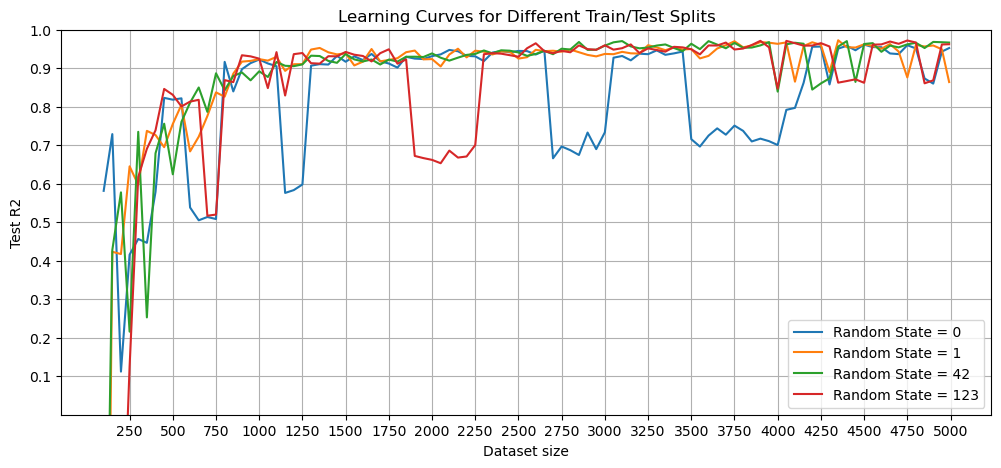

In [12]:
# plot learning curves for different train/test splits for test R2
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rslts_pd['R2_test_subsample'],label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rslts_pd['R2_test_subsample'],label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rslts_pd['R2_test_subsample'],label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rslts_pd['R2_test_subsample'],label='Random State = 123')
plt.title('Learning Curves for Different Train/Test Splits')
plt.xlabel('Dataset size')
plt.ylabel('Test R2')
plt.legend()
plt.grid()
plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])
plt.ylim(0,1)

([<matplotlib.axis.XTick at 0x201160b1c40>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

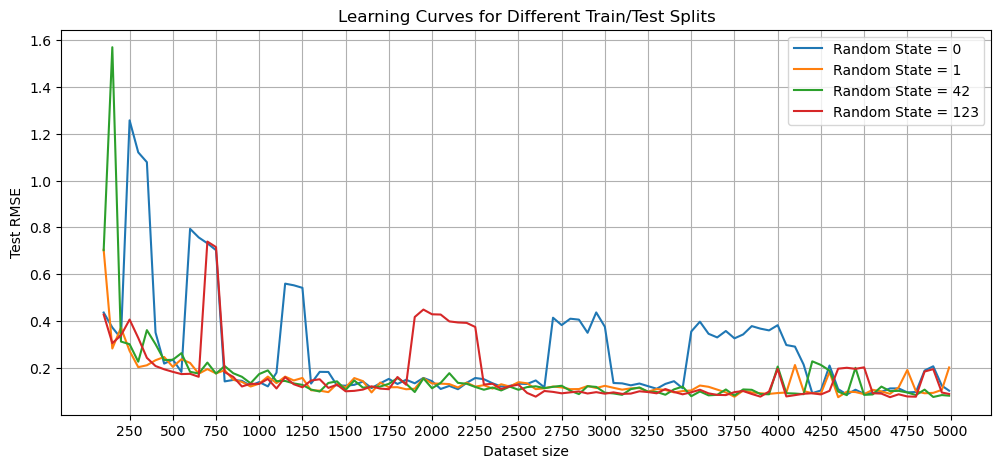

In [13]:
# plot learning curves for different train/test splits for test rmse
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rslts_pd['rmse_test_subsample'],label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rslts_pd['rmse_test_subsample'],label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rslts_pd['rmse_test_subsample'],label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rslts_pd['rmse_test_subsample'],label='Random State = 123')
plt.title('Learning Curves for Different Train/Test Splits')
plt.xlabel('Dataset size')
plt.ylabel('Test RMSE')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

([<matplotlib.axis.XTick at 0x201163adaf0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

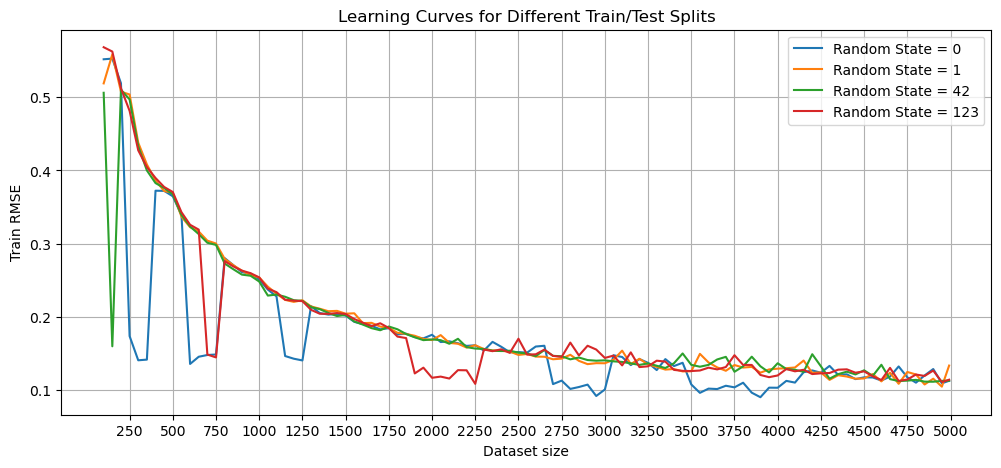

In [14]:
# plot learning curves for different train/test splits for train rmse
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rslts_pd['rmse_train_subsample'],label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rslts_pd['rmse_train_subsample'],label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rslts_pd['rmse_train_subsample'],label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rslts_pd['rmse_train_subsample'],label='Random State = 123')
plt.title('Learning Curves for Different Train/Test Splits')
plt.xlabel('Dataset size')
plt.ylabel('Train RMSE')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

In [15]:
# train R2 - test R2
randomstate0_R2diff = randomstate0_rslts_pd['R2_train_subsample'] - randomstate0_rslts_pd['R2_test_subsample']
randomstate1_R2diff = randomstate1_rslts_pd['R2_train_subsample'] - randomstate1_rslts_pd['R2_test_subsample']
randomstate42_R2diff = randomstate42_rslts_pd['R2_train_subsample'] - randomstate42_rslts_pd['R2_test_subsample']
randomstate123_R2diff = randomstate123_rslts_pd['R2_train_subsample'] - randomstate123_rslts_pd['R2_test_subsample']

# test RMSE - train RMSE
randomstate0_rmsediff = randomstate0_rslts_pd['rmse_test_subsample'] - randomstate0_rslts_pd['rmse_train_subsample']
randomstate1_rmsediff = randomstate1_rslts_pd['rmse_test_subsample'] - randomstate1_rslts_pd['rmse_train_subsample']
randomstate42_rmsediff = randomstate42_rslts_pd['rmse_test_subsample'] - randomstate42_rslts_pd['rmse_train_subsample']
randomstate123_rmsediff = randomstate123_rslts_pd['rmse_test_subsample'] - randomstate123_rslts_pd['rmse_train_subsample']



([<matplotlib.axis.XTick at 0x20116355700>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

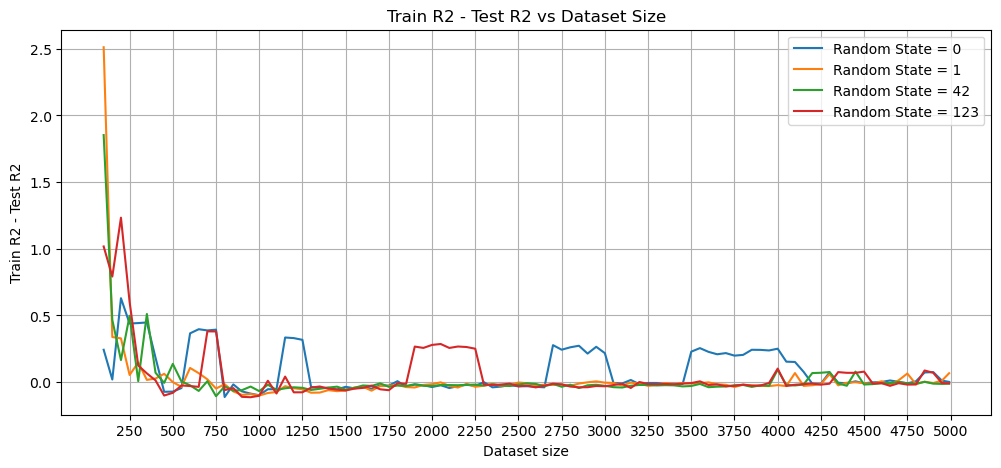

In [16]:
# plot R2 diff vs dataset size
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_R2diff,label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_R2diff,label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_R2diff,label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_R2diff,label='Random State = 123')
plt.title('Train R2 - Test R2 vs Dataset Size')
plt.xlabel('Dataset size')
plt.ylabel('Train R2 - Test R2')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

([<matplotlib.axis.XTick at 0x201161f78e0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

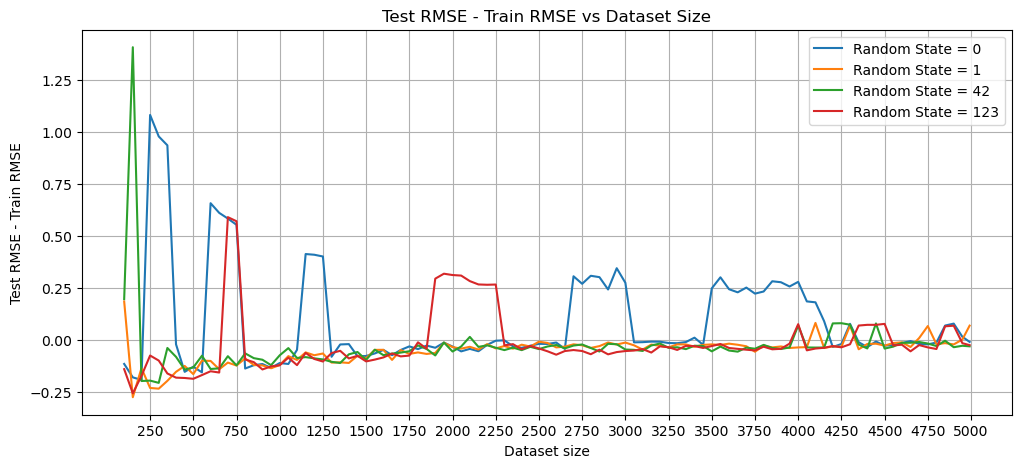

In [17]:
# plot rmse diff vs dataset size
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rmsediff,label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rmsediff,label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rmsediff,label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rmsediff,label='Random State = 123')
plt.title('Test RMSE - Train RMSE vs Dataset Size')
plt.xlabel('Dataset size')
plt.ylabel('Test RMSE - Train RMSE')
plt.legend()
plt.grid()
#plt.ylim([-0.1,0.8])
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

In [18]:
# concatenate results for each random_state value into one dataframe for output into Excel
rslts_formatted = pd.concat([randomstate0_rslts_pd,randomstate1_rslts_pd,randomstate42_rslts_pd,randomstate123_rslts_pd],axis=1)
rslts_formatted

,num_samples,num_outliers,R2_train_subsample,rmse_train_subsample,mape_train_subsample,R2_test_subsample,rmse_test_subsample,mape_test_subsample,num_samples,num_outliers,...,rmse_test_subsample,mape_test_subsample,num_samples,num_outliers,R2_train_subsample,rmse_train_subsample,mape_train_subsample,R2_test_subsample,rmse_test_subsample,mape_test_subsample
0,100.0,2.0,0.824551,0.551957,0.220178,0.581483,0.436526,0.325152,100.0,2.0,...,0.702765,0.296281,100.0,2.0,0.821766,0.568442,0.217551,-0.195866,0.427863,0.301544
1,150.0,3.0,0.748541,0.552837,0.198864,0.728879,0.372670,0.248888,150.0,3.0,...,1.568892,0.188264,150.0,3.0,0.759695,0.562523,0.194798,-0.032360,0.305646,0.204411
2,200.0,3.0,0.741752,0.519183,0.182746,0.111989,0.326813,0.226668,200.0,3.0,...,0.312676,0.268541,200.0,3.0,0.749433,0.512288,0.188851,-0.484213,0.338869,0.244125
3,250.0,3.0,0.855275,0.173375,0.127197,0.415738,1.256771,0.156262,250.0,3.0,...,0.301284,0.238910,250.0,3.0,0.727108,0.481386,0.176820,0.125251,0.406507,0.268076
4,300.0,3.0,0.899593,0.140299,0.105021,0.456438,1.120191,0.153662,300.0,3.0,...,0.226630,0.155570,300.0,3.0,0.742116,0.427404,0.150023,0.617505,0.328200,0.191873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,4800.0,35.0,0.957698,0.109703,0.038049,0.951368,0.097277,0.046392,4800.0,35.0,...,0.084322,0.047322,4800.0,35.0,0.949319,0.120840,0.041111,0.966717,0.077256,0.049092
95,4850.0,36.0,0.945891,0.119530,0.040719,0.873330,0.188822,0.047440,4850.0,36.0,...,0.107406,0.048222,4850.0,36.0,0.948260,0.118871,0.038804,0.860830,0.184602,0.045635
96,4900.0,36.0,0.935615,0.128352,0.041512,0.860011,0.207067,0.047313,4900.0,36.0,...,0.076053,0.044350,4900.0,36.0,0.938785,0.126251,0.042043,0.868464,0.194936,0.048147
97,4950.0,36.0,0.954901,0.108818,0.038037,0.943265,0.124104,0.046854,4950.0,36.0,...,0.084180,0.046115,4950.0,36.0,0.955002,0.110593,0.038296,0.961676,0.095094,0.047542


In [19]:
# output results to Excel
book = load_workbook(parentdir+'\\ML Models Results\\Model1b_Results.xlsx')
writer = pd.ExcelWriter(parentdir+'\\ML Models Results\\Model1b_Results.xlsx', engine='openpyxl') 
writer.book = book
writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
rslts_formatted.to_excel(writer, 'FORMATTED')
writer.save()
writer.close()